# Tacotron and Tacotron2 

模型结构上，tacotron2与tacotron基本类似，除了CBHG结构和Griffin结构上略有区别

### Tacotron

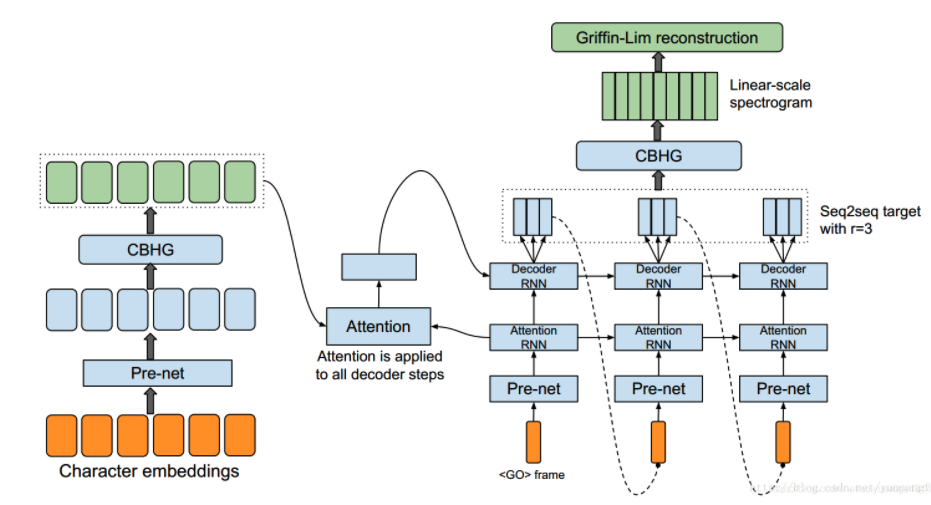

Tacotron模型是首个真正意义上的端到端TTS深度神经网络模型。与传统语音合成相比，它没有复杂的语音学和声学特征模块，而是仅用<文本序列，语音声谱>配对数据集对神经网络进行训练，因此简化了很多流程。然后Tacotron使用Griffin-Lim算法对网络预测的幅度谱进行相位估计，再接一个短时傅里叶（Short-Time Fourier Transform，STFT）逆变换，实现端到端语音合成的功能。

### Tacotron2

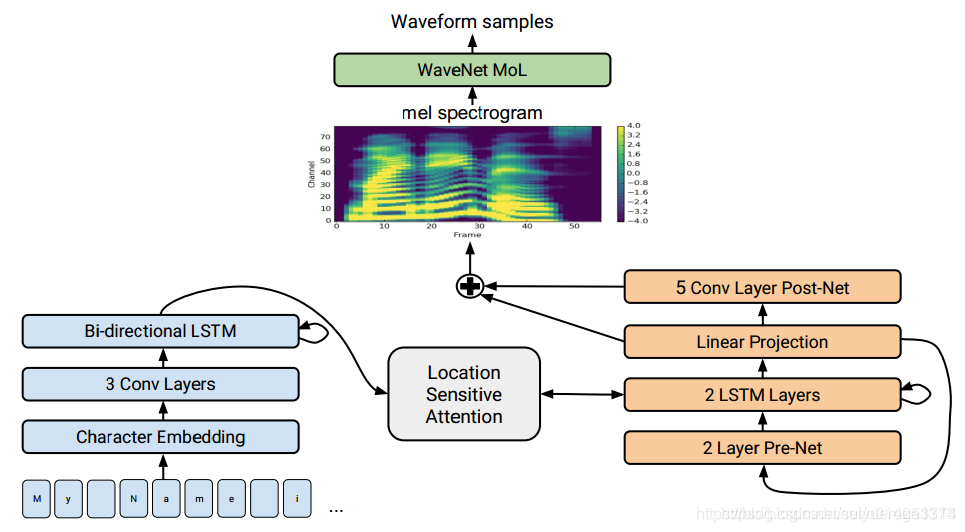


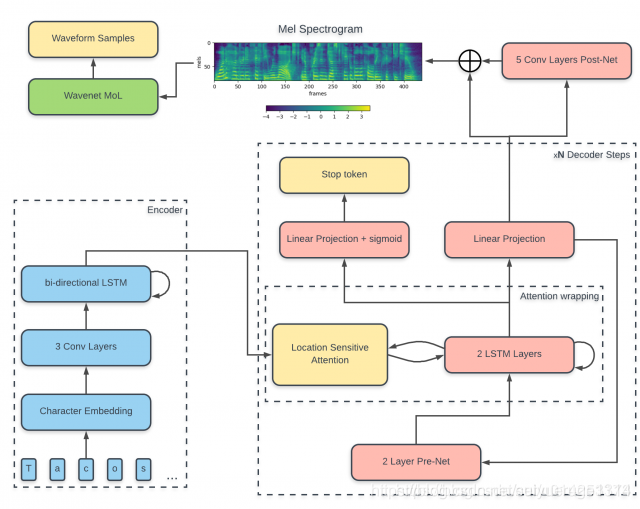

### 重点区别：

1. encoder部分，使用了embedding + 3Conv_layers + Bi-directional_LSTM

2. attention使用的是location sensitive attention

3. Pre_net的dropout是一直设置为 true 的（据说是根据实验效果），post_net中最后一层一般为linear激活函数

4. 最后的 mel_output_post 是经过 post_net 和 linear_projection相加得到

5. 多帧预测方面，虽然Tacotron2没有使用多帧，但是实现原理类似

## Model (Spectrogram Prediction Network 声谱预测网络）

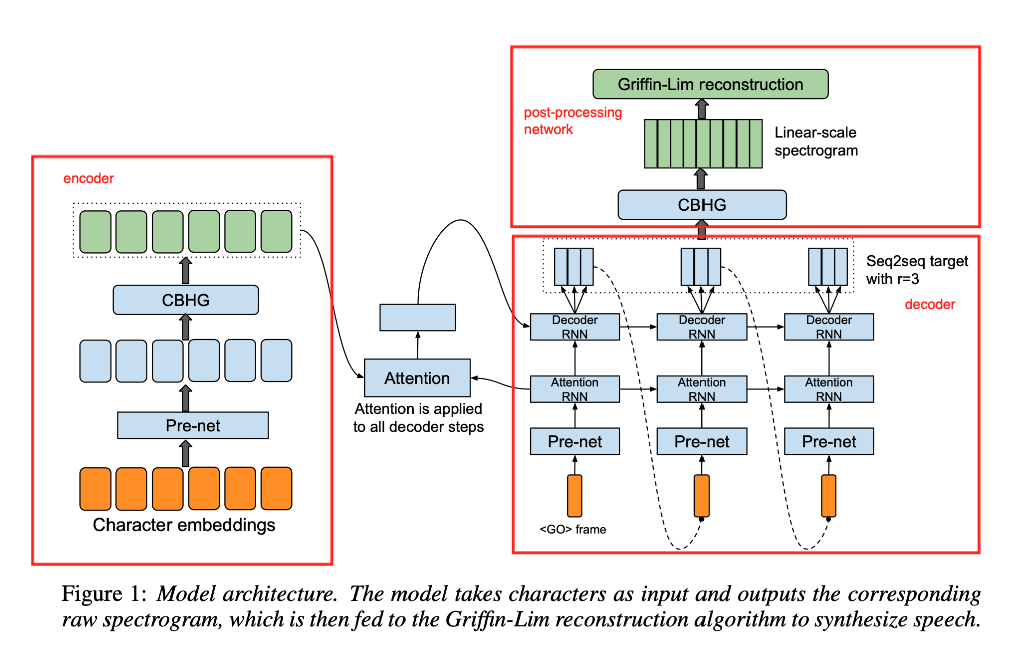

也可以表示为：

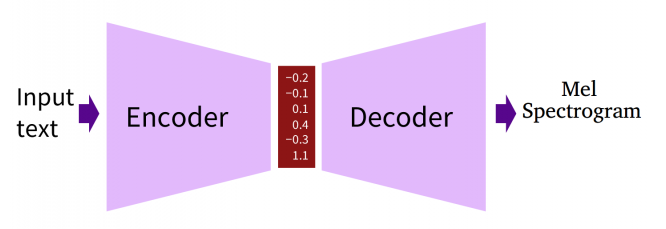

通常我们将RNN的输入称为'context(上下文)'，我们希望通过encoder来产生此上下文的向量。

- encoder输入一个序列或句子，然后将其压缩到一个固定长度的向量(向量也可以理解为一种形式的序列)中

- decoder使用固定长度的向量，利用attention关注向量的不同部分，将其解压成一个序列。

## Tacotron 的 Encoder

### 1. Character Embedding  

将文本转为one-hot向量，embedding之后的shape:[N, T, 256], 256为word_dim

### 2. Pre-net

pre-net是一个3层的网络结构，其主要功能是对输入进行一系列的非线性的变换，这样有助于模型收敛和泛化。

它有两个隐藏层，层与层之间的连接均是全连接；第一层的隐藏单元数目与输入单元数目一致[N,T,256]->[N,T,256]，第二层的隐藏单元数目为第一层的一半[N,T,256]->[N,T,128]；两个隐藏层采用的激活函数均为ReLu，并保持0.5的dropout来提高泛化能力。

基于tensorflow实现prenet的代码：

In [ ]:
# Encoder
#hp.prenet_depths=[256, 128]
prenet_outputs = prenet(embedded_inputs, is_training, hp.prenet_depths)    # [N, T_in, prenet_depths[-1]=128]

def prenet(inputs, is_training, layer_sizes, scope=None):
    '''Args:
    inputs:输入的tensor,[N,T,256],其中N：batchsize T:输入文本长度
    is_training:布尔值
    layer_size:prenet一共有两层隐藏层,第一层为256个hidden units,第二层为128个hidden units
    '''
    x = inputs
    drop_rate = 0.5 if is_training else 0.0
    with tf.variable_scope(scope or 'prenet'):
        for i, size in enumerate(layer_sizes):
        dense = tf.layers.dense(x, units=size, activation=tf.nn.relu, name='dense_%d' % (i+1))
        x = tf.layers.dropout(dense, rate=drop_rate, training=is_training, name='dropout_%d' % (i+1))
    return x

### 3. Encoder_cbhg

encoder_cbhg是输入端的cbhg,包括convolution bank, hignway network, BiGRU. CBHG最初源于机器翻译，主要用于提高模型的泛化能力。结构如下：

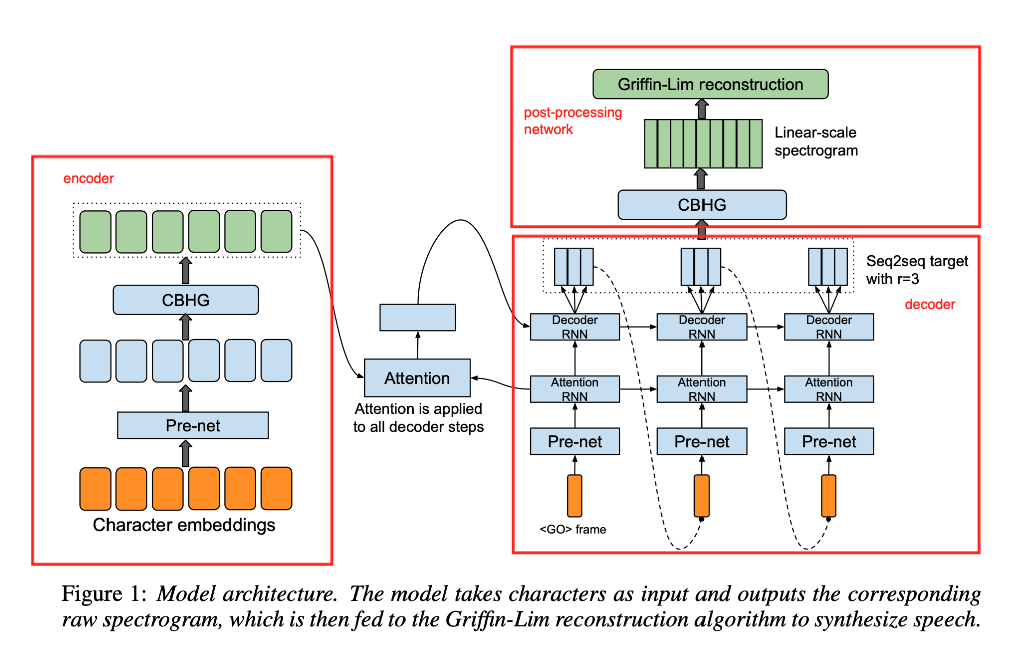

#### 3.1 Convolution Bank

这部分对于特征提取的思路是用 height=1, width=word_dim 的 filter 过滤得到一个 input_embedding 的特征值，然后相邻两个 word 一起过滤得到局部窗口为2的上下文特征值，即 2-gram,一直提取到 16-gram. 128个 filter 用于关注不同的特征值。

- 是 n-gram 的思想

- encoder_cbhg 使用的 kernel_size 为 [1,2,...,16] filter_size=128

- 每个 conv1d 结果按照 axis=-1 拼接起来后的 shape 为 [N, T, 128 \* 16]

#### 3.2 Maxpool1d

maxpool相当于特征筛选，挑选出相邻两个时间步更加突出的特征(更大的值),shape 为 [N, T, 128 \* 16]

#### 3.3 projection

对于encoder_cbhg projections = [128,input_channels] 由于 encoder_cbhg 的输入为 prenet [N, T,128]而 input_channels = inputs.get_shape()[2] 故而 encoder_cbhg projections = [128,128]

#### 3.4 residual connection

残差网络思想 [N, T, 128]

#### 3.5 HighWay Net

把输入同时放入到两个一层的全连接网络中，这两个网络的激活函数分别采用了ReLu和sigmoid函数，假定输入为input，ReLu的输出为output1，sigmoid的输出为output2，那么highway layer的输出为：output=output1∗output2+input∗（1−output2).

#### 3.6 BiGRU

双向拼接，所以shape=[N, T, 256]

In [ ]:
def highwaynet(inputs, scope, depth):
    with tf.variable_scope(scope):
        H = tf.layers.dense(inputs, units=depth, activation=tf.nn.relu, name='H')
        T = tf.layers.dense(inputs, units=depth, activation=tf.nn.sigmoid, name='T', bias_initializer=tf.constant_initializer(-1.0))
        return H * T + inputs * (1.0 - T)

In [ ]:
encoder_outputs = encoder_cbhg(prenet_outputs, input_lengths, is_training, hp.encoder_depth)  # encoder_outputs=[N, T, encoder_depth=256]

def encoder_cbhg(inputs, input_lengths, is_training, depth):
    input_channels = inputs.get_shape()[2]
    return cbhg(inputs, input_lengths, is_training, scope='encoder_cbhg', K=16, projections=[128, input_channels], depth=depth)

def cbhg(inputs, input_lengths, is_training, scope, K, projections, depth):
    '''
    Args:
        inputs:输入的tensor(也是pre-net的输出) [N, T, 128]
        input_lengths:输入的文本的长度,形状为[N],代表一个batch中每一条文本的长度组成的向量
        is_training:布尔值
        K:int,代表第一层卷积里卷积核的个数
        projections:代表第二个卷积层中每次卷积之后的输出长度
    '''
    with tf.variable_scope(scope):
        with tf.variable_scope('conv_bank'):
        # Convolution bank: concatenate on the last axis to stack channels from all convolutions
        conv_outputs = tf.concat([conv1d(inputs, k, 128, tf.nn.relu, is_training, 'conv1d_%d' % k) for k in range(1, K+1)], axis=-1) #K=16

    # Maxpooling:
    maxpool_output = tf.layers.max_pooling1d(conv_outputs, pool_size=2, strides=1, padding='same') #[N,T,128*16]

    # Two projection layers:
    proj1_output = conv1d(maxpool_output, 3, projections[0], tf.nn.relu, is_training, 'proj_1')
    proj2_output = conv1d(proj1_output, 3, projections[1], None, is_training, 'proj_2') # proj2 没有采用激活函数

    # Residual connection:
    highway_input = proj2_output + inputs

    half_depth = depth // 2
    assert half_depth*2 == depth, 'encoder and postnet depths must be even.'

    # Handle dimensionality mismatch:
    if highway_input.shape[2] != half_depth:
        highway_input = tf.layers.dense(highway_input, half_depth)

    # 4-layer HighwayNet:
    for i in range(4):
        highway_input = highwaynet(highway_input, 'highway_%d' % (i+1), half_depth)
    rnn_input = highway_input

    # Bidirectional RNN
    outputs, states = tf.nn.bidirectional_dynamic_rnn(GRUCell(half_depth), GRUCell(half_depth), rnn_input, sequence_length=input_lengths, dtype=tf.float32)
    return tf.concat(outputs, axis=2)  # Concat forward and backward

In [ ]:
def conv1d(inputs, kernel_size, channels, activation, is_training, scope):
    with tf.variable_scope(scope):
        conv1d_output = tf.layers.conv1d(inputs, filters=channels, kernel_size=kernel_size, activation=activation, padding='same')
        return tf.layers.batch_normalization(conv1d_output, training=is_training)

## Tacotron2

整个特征预测网络是一个带注意力机制的seq2seq网络，用于将输入的字符序列预测为梅尔频谱的帧序列。

### Encoder-Decoder结构

在原始的编码器-解码器结构中，编码器输入一个序列或句子，然后将其压缩到一个固定长度的向量(向量也可以理解为一种形式的序列)中；解码器使用固定长度的向量，将其解压成一个序列。

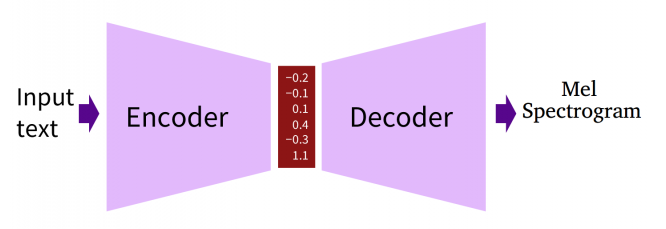

### Encoder 

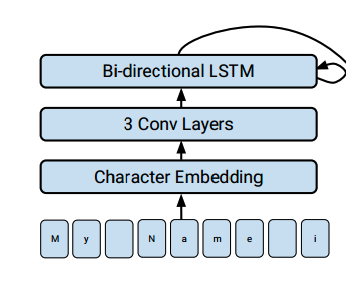

在Tacotron2中，编码器模块包括卷积层和BiLSTM层。Tacotron2中conv_layer给予了neural net类似于N-gram感知上下文的能力,主要是由于RNN很难捕获长时依赖，并且conv-layer使得模型对不发音字符更有鲁棒性(如 'know'中的'k')

Passes inputs through a stack of convolutional layers then through a bidirectional LSTM layer to predict the hidden representation vector(编码器隐状态).Bi-directional LSTM 中的 LSTM 为 ZoneoutLSTM. 用bi-directional-RNN是为了确保模型能够同时感知前向和后向的信息。

其中**ZoneoutLSTM**: A method for regularizing RNN. At each steps, zoneout stochastically forces some hidden units to maintain their previous values. Zoneout uses random noises to train a pseudo-ensemble, improving generalization. By preserving instead of dropping hidden units, gradient information and state information are more readily propagated through time, as in feedforward stochastic depth networks.
LSTM is defined as follow:

$$i_t,f_t,o_t=\sigma(W_xx_t+W_th_{h-1}+b)$$
$$g_t=tanh(W_{xg} x_t+W_{hg}h_{t-1}+b_g)$$
$$c_t=f_t \odot c_{t-1}+i_t \odot g_t$$
$$h_t=o_t \odot tanh(c_t)$$

编码器隐状态生成后，就会将其送入注意力网络(attention network)中生成上下文向量(context vector)

zoneoutLSTM is defined as follow:

$$c_t=d_t^c \odot c_{t-1}+(1-d^c_t) \odot (f_t \odot c_{t-1}+i_t \odot g_t)$$
          
$$h_t=d_t^h \odot h_{t-1}+(1-d^h_t) \odot (o_t \odot tanh(c_t))$$

Now we get encoder features（context vector）

### Attention mechanism

注意力用作编码器和解码器的桥梁，本质是一个上下文权重向量组成的矩阵。

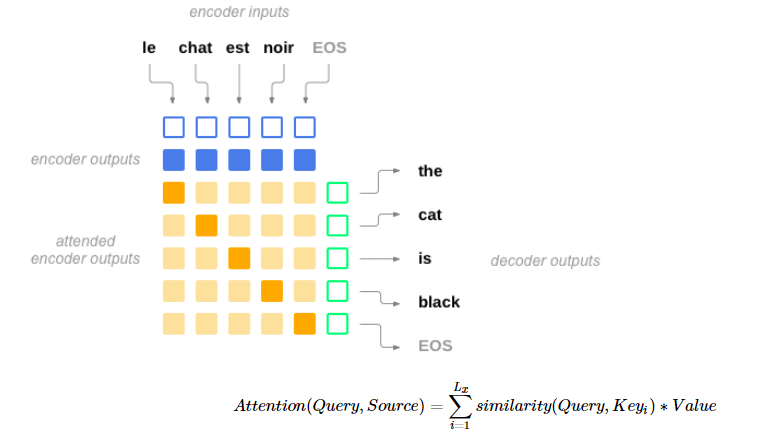

在tacotron2中，attention computation 发生在每一个解码器时间步上，其中包含以下阶段：

1. 目标隐函数(上图绿框所示)与每一个源状态(上图蓝框所示)"相比"，以生成attention weights(注意力权重)或alignments(对齐)

$$\alpha_{ts}=\frac{exp(score(h_t,\bar{h_s}))}{\sum_{s'=1}^{S}exp(score(h_t,\bar{h_s'}))}$$

其中$h_t$为目标隐状态，$\bar{h_s}$为源状态，$score$函数常被称作"能量(energy)"，因此可以表示为$e$.不同的$score$函数决定了不同类型的attention mechanism. 

2. 基于注意力权重，计算上下文向量(context vector)作为源状态的加权平均:

$$c_t=\sum_s \alpha_{ts} \bar{h_s}$$

3. 注意力向量作为下一个时间步的输入

以下是不同score的函数：

1. 基于内容的注意力机制(content-based attention):

$$e_{ij}=score(s_{i-1},h_j)=v_a^T tanh(W_a s_{i-1} + U_a h_j)$$

其中，$s_{i-1}$ 为上一个时间步中解码器的输出(解码器隐状态，decoder hidden states)，$h_j$ 是编码器此刻输入(编码器隐状态，encoder hidden state j)，$v_a$、$W_a$ 和 $U_a$ 是待训练参数张量。由于 $U_a h_j$ 是独立于解码步 $i$ 的，因此可以独立提前计算。基于内容的注意力机制能够将不同的输出与相应的输入元素连接，而与其位置无关。在Tacotron2中使用基于内容的注意力机制时，当输出对应于's'的Mel频谱帧，模型会寻找所有对应于's'的输入。

2. 基于位置的注意力机制(location-based attention):

$$e_{ij}=score(\alpha_{i-1},h_j)=v_a^T tanh(W h_j+Uf_{i,j})$$

其中，$f_{i,j}$ 是之前的注意力权重 $\alpha_{i-1}$ 经卷积而得到的位置特征，$f_i=F*\alpha_{i-1}$，$v_a$、$W_a$、$U_a$ 和 $F$ 是待训练参数。

基于位置的注意力机制仅关心序列元素的位置和他们之间的距离。基于位置的注意力机制会忽略静音或减少他们，因此该注意力机制没有发现输入的内容。

3. 混合注意力机制(hybrid attention)

顾名思义，混合注意力机制是上述两者注意力机制的结合：

$$e_{ij}=score(s_{i-1},\alpha_{i-1},h_j)=v_a^T tanh(W s_{i-1} + Vh_j + Uf_{i,j})$$

其中，$s_{i-1}$ 为之前的解码器隐状态，$\alpha_{i-1}$ 是之前的注意力权重，$h_j$ 是第 $j$ 个编码器隐状态。为其添加偏置值 $b$, 最终的score函数计算如下：

$$e_{ij}=v_a^Ttanh(W{s_{i-1}}+Vh_j+Uf_{i,j}+b)$$

其中，$v_a$、$W$、$V$、$U$ 和 $b$ 为待训练参数，$s_{i-1}$ 是上一个时间步中解码器隐状态，$h_j$ 是当前编码器隐状态，$f_{i,j}$ 是之前的注意力权重 $\alpha_{i-1}$ 经卷积而得的位置特征(location feature),$f_i=F * \alpha_{i-1}$。混合注意力机制能够同时考虑内容和输入元素的位置。

Tacotron2中使用的是Location Sensitive Attention
                                      
$$e_{ij}=score(s_{i},c\alpha_{i-1},h_j)=v_a^Ttanh(W{s_{i}}+Vh_j+Uf_{i,j}+b)$$
                                      
其中$s_{i}$为当前解码器的输出(解码器隐状态 decoder hidden states)，$h_j$是第$j$个编码器此刻输出(编码器隐状态 encoder hidden state)，位置特征$f_{i,j}$使用累加是attention weight $c\alpha_{i}$经卷积而得的位置特征

$$f_i=F*c\alpha_{i-1},c\alpha_i=\sum_{j=1}^{i-1}\alpha_j$$

之所以使用加法累加而非乘法累积原因如图：

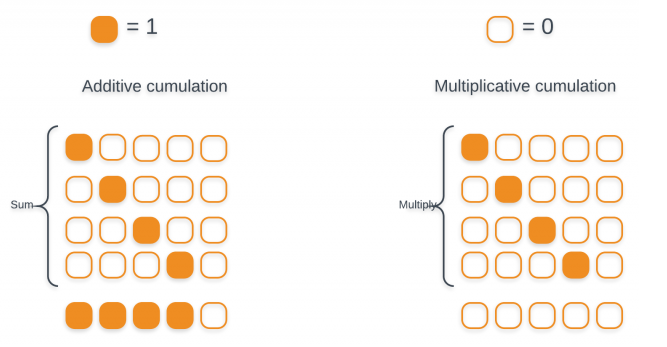

累加注意力权重，可以使得注意力权重网络了解它已经学习到的注意力信息，使得模型能在序列中持续进行并且避免重复未预料的语音。

整个注意力机制如图：

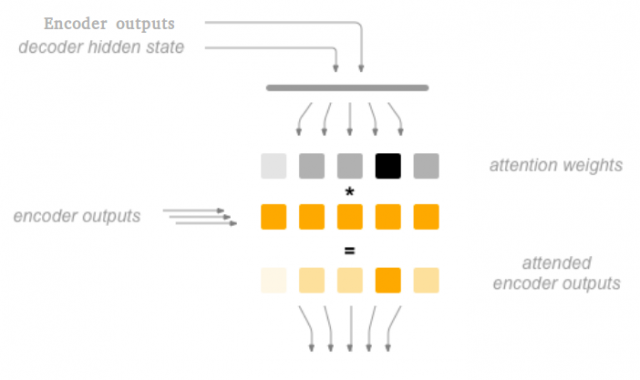

### Attention

Attention mechanism 是一种人类大脑信号处理机制，被人类用于快速筛选关键信息，大大提高了人类对信息处理的效率与准确性。它也常常被用于深度学习中的seq2seq model中，使得模型能够关注到输入序列的关键讯息。在文本到语音合成的任务中，注意力机制也起到了重要的作用。它通过在合理分配序列中每个元素所占的权重，从而使得模型对序列的各个部分的关注程度不同，更关注于与合成内容更密切相关的部分。此外，注意力机制还能关注输入序列与输出序列间可能存在的关联，在文本到语音合成任务中被用于对齐输入的文本序列与输出的语音序列。

注意力机制的种类繁多，在Tacotron2中使用的是混合注意力机制（Hbrid Attention），它有效地结合了基于内容的注意力机制（Content-based Attention）与基于位置的注意力机制（Location-based Attention）。使用了混合注意力机制的注意力模块被用于连接编码器与解码器。注意力机制本质上是对编码器输出的序列中元素的值（Value）进行加权求和，而查询（Query）与键（Key）则被用于计算对应值得权重系数。在此处，我们定义编码器的隐状态为$h=(h_1,\cdots,h_L)$，输入的梅尔谱图序列为 $x=(x_1,\cdots,x_L)$，注意力模块计算后的输出序列为 $y=(y_1,\cdots,y_T)$，那么在第 $i$ 步中注意力机制通过对隐状态 $h$ 的计算来生成 $y_i$：

$$\alpha_i = \text{Attention}(s_{i-1},g_i,y_i)$$

$$g_i = \sum_{j=1}^L \alpha_{i,j} h_j$$

$$y_i \sim \text{Generate}(s_{i-1},g_i)$$

其中 $s_{i-1}$ 是第 $i-1$ 步时的生成状态；此外，我们定义向量 $\alpha_i$，其维度为 $L$，注意力机制中的权重系数。根据上述公式以及描述，可以计算第 $i$ 步时的生成状态 $s_i$:

$$s_i = \text{Recurrency}(s_{i-1},g_i,y_i)$$

在混合注意力机制中，除了上述的基于内容的注意力机制，还结合了基于位置的注意力机制。基于位置的注意力机制需要保证处理序列时的前后顺序具有一致性，因此引入维度为 $k$ 的向量 $f_{i,j}$ 用于存储该步之前所累积的注意力权重。$f_i$ 可由矩阵 $F$ 与 $\alpha_{i-1}$ 进行卷积运算后得出，而后对 $f_i$ 进行拓展的计算后经过tanh激活函数得到当前位置 $i$ 与隐藏状态位置 $i$ 的对齐得分 $e_{i,j}$。

$$f_i=F \cdot \alpha_{i-1}$$

$$e_{i,j}=w^T \text{tanh}(W s_{i-1}+Vh_j+Uf_{i,j}+b)$$

最后，混合注意力机制需要将计算出的对其得分 $e_{i,j}$ 送入Softmax函数，从而可以计算出权重系数 $\alpha_{i,j}$.

## Decoder Block

解码器是一个自回归RNN，解码过程从输入上一步的输出声谱或上一步的真实声谱到prenet开始，解码过程如图：

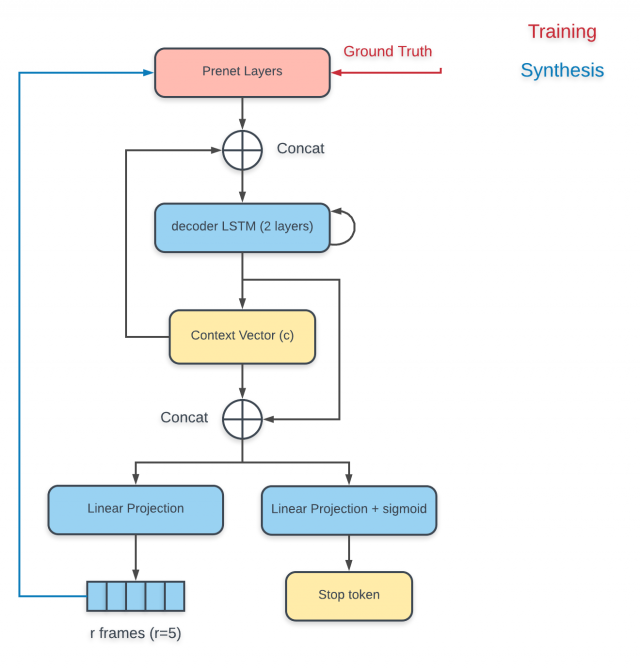

解码器模块是一个自回归的循环神经网络，它将编码序列按时间步依次转换为输出帧作为预测声谱。自回归是通过两个全连接层组成的预处理网络（Pre-Net）实现：解码器上一步预测的频谱帧回传给Pre-Net，然后将其输出与上下文拼接，传递给两个堆叠起来的1024单元LSTM层。LSTM的输出再与上下文向量拼接在一起，经过一个线性投影层(projection layer)来预测目标频谱帧。

输出有两种形式，一种是声谱帧，一种是<𝑠𝑡𝑜𝑝 𝑡𝑜𝑘𝑒𝑛>的概率，后者是一个简单二分类问题，决定解码过程是否结束。Tacotron2设计了一个停止标志（Stop Token）来预测输出序列完成与否的概率。它与解码器中帧预测网络平行，将LSTM层输出与注意力向量拼接结果投影成一个标量，再经过sigmoid激活函数预测输出序列生成结束的概率。从而根据该概率训练模型动态地决策何时结束频谱生成操作，通常设置结束概率的阈值为0.5。使用缩减因子(reduction factor)即每一个解码步仅允许预测𝑟(缩减因子)Mel谱帧，能够有效加速计算，减小内存占用。

## Post-Net

一旦解码器完成解码，预测得到的Mel谱被送入一系列的卷积层以提高生成质量。

通过将预测频谱帧传递给包含5个卷积层的后处理网络（Post-Net）来预测一个残差项，并将其叠加到预测帧中。

$$y_{final}=y+y_r$$

其中 $y$ 为原始输入，上式中，

$$y_r = \text{PostNet}(y)=W_{ps}f_{ps}+b_{ps}$$

其中，$f_{ps}=F_{ps,i}*x$，$x$ 为上一个卷积层的输出或解码器输出，$F$ 为卷积

Post-Net的卷积层均由512个5×1的卷积核构成，每层后接批标准化和tanh激活函数处理。为及时终止自回归循环网络的预测帧操作，

Tacotron2的Decoder部分是由以下五部分构成：

1. Prenet ： 2层Fc全连接

2. LocationSensitiveAttention

3. LSTM：两层ZoneOutLSTM组成

4. FrameProjection: 1层Dense , no activation, 为了调整输出维度

5. StopProjection : 1层Dense, activation = sigmoid

## 训练

$$loss=\frac{1}{n}\sum_{i=1}^n (y_{real,i}-y_i)^2 + \frac{1}{n}\sum_{i=1}^n (y_{real,i} - y_{final,i})^2 + \lambda \sum_{j=1}^p w_j^2$$

其中，$y_{real,i}$ 为真实声谱，$y_i, y_{final,i}$ 分别为进入后处理网络前、后的声谱，$n$ 为batch中的样本数，$\lambda$ 为正则化参数，$p$ 为参数总数，$w$为神经网络中的参数。注意，不需要正则化偏置值。

## Vocoder

声码器（Vocoder）在语音合成中往往被用于将生成的语音特征转换为我们所需要的语音波形。在Tacotron2中，由于前端的神经网络所预测出的梅尔谱图仅包含了幅值信息而缺乏相应的相位信息，我们难以直接通过短时傅里叶变换（STFT）的逆变换将梅尔谱图还原为声音波形文件；因此，我们需要使用声码器进行相位估计，并将输入的梅尔谱图转换为语音波形。

​ ​ ​ ​ Griffin-Lim算法是一种常见的传统声码器，其无需训练，通过帧与帧之间的关系估计相位信息。然而，其合成的音频存在携带特有的人工痕迹并且语音质量较低的问题。因此，Tacotron2中使用了基于神经网络的声码器WaveNet替代了Griffin-Lim算法。

​ ​ ​ ​ WaveNet模型是一种序列生成模型，在语音合成中主要被用作为声码器。其通过一个序列的前t − 1 t-1t−1个点预测第t tt个点的结果，因此可以用于预测语音波形中的采样点数值：